<a href="https://colab.research.google.com/github/IgorQuaresma/SirioLibanesKaggle/blob/main/Notebooks/Bootcamp_PF_MachineLearningModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning

## Introduction

This notebook is the part 3 of 3 notebooks that composes the whole project. The notebook is going to use the data from the pre-proccessing step (part 1) and insights from the exploratory analysis that was done in part 2.

## Importing the libs

In [1]:
!pip install yellowbrick

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
import seaborn as sns
import sklearn as skl

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from yellowbrick.features import FeatureImportances 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Functions

In [20]:
def separate_train_test(data):
  '''separates the train and test data '''
  np.random.seed(1234525)
  x_columns = data.columns 
  y = data['ICU']
  x = data[x_columns].drop(['ICU','WINDOW'],axis=1)
  x_train,x_test,y_train,y_test = train_test_split(x, y, stratify = y, test_size=0.2)
  return x_train,x_test,y_train,y_test

In [21]:
def accuracy(data, model, name):
  '''returns the value of accuracy'''
  model = model
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  predict = model.predict(x_test)

  print(f'The accuracy of the {name} model is: {(accuracy_score(y_test, predict))*100 :.2f}% ')

In [22]:
def run_model(data, model):
  '''Returns the Classication Report with the following metrics: recall,f1-score e support'''
  #separating train and test data
  x_train, x_test, y_train, y_test = separate_train_test(data)

  #creating the model
  model.fit(x_train,y_train)
  predict = model.predict(x_test)
  proba_predict = model.predict_proba(x_test)
  
  #return the auc
  auc = roc_auc_score(y_test,proba_predict[:,1])
  print(f'AUC = {auc}')
  print("\nClassification Report")
  print(classification_report(y_test, predict))

In [69]:
def run_model_cv(model, data, n_splits, n_repeats):
  '''Returns the mean test and train auc of an specific model'''
  #separating train and test data
  np.random.seed(1234525) 
  data = data.sample(frac = 1).reset_index(drop = True) 
  x_columns = data.columns 
  y = data['ICU']
  x = data[x_columns].drop(['ICU','WINDOW'], axis=1)

  #creating the model
  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
  results = cross_validate(model,x,y,cv=cv,scoring = 'roc_auc', return_train_score=True) 

  #return the auc
  mean_auc = np.mean(results['test_score']) 
  mean_auc_train = np.mean(results['train_score']) 
  auc_std = np.std(results['test_score'])
  print(f'AUC TEST = {mean_auc} --- AUC TRAIN = {mean_auc_train}')
  return mean_auc, mean_auc_train

In [24]:
def decision_tree_model(data, criterion , max_depth, splitter):
  '''Returns the decision tree model results'''
  #Creating the model
  model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, splitter=splitter )
  
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  
  #Criando a predição
  predict = model.predict(x_test)
  
  return model, predict

In [25]:
def logistic_regression_model(data, penalty, c, solver, max_iter, multi_class):
  '''Returns the logistic regression model results'''
  #Creating the model
  model = LogisticRegression(penalty=penalty, C=c, solver=solver, max_iter=max_iter, multi_class=multi_class)
  
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
  
  #Predicting
  predict = model.predict(x_test)
  
  return model, predict

In [26]:
def random_forest_model(data, n_est, max_feat, max_depth, bootstrap, oob_score, criterion, min_samples_leaf, min_impurity_decrease ):
  '''Returns therandom forest model results'''
  #Creating the model
  model = RandomForestClassifier(n_estimators=n_est, 
                                 max_features=max_feat,
                                 max_depth=max_depth, 
                                 bootstrap=bootstrap,
                                 oob_score=oob_score, 
                                 criterion=criterion, 
                                 min_samples_leaf=min_samples_leaf,
                                 min_impurity_decrease=min_impurity_decrease)
 
  #separating train and test data
  x_train,x_test,y_train,y_test = separate_train_test(data)
  model.fit(x_train,y_train)
 
  #Predicting
  predict = model.predict(x_test)
  
  return model, predict

In [51]:
def roc_plot(model, name_model, data):
  '''Plots the roc curve'''
  
  # divide data
  x_train, x_test, y_train, y_test = separate_train_test(data)
  
  # create figure
  fig = plt.subplots(figsize=(10, 10))
  ax = plt.axes()

  # plot the curve
  plot_roc_curve(model, x_test, y_test, ax=ax, color='r')

  # define labels and title
  plt.title(f'ROC curve for the {name_model} model \n', fontsize=20, fontweight='bold',
           color='black')
  plt.ylabel('Razão de Verdadeiro Positivo (VP)', fontsize=11, color='dimgrey',
             fontweight='bold')
  plt.xlabel('Razão de Falto Positivo (FP)', fontsize=11, color='dimgrey',
             fontweight='bold')

  
  ax.spines['bottom'].set_color('silver')
  ax.spines['left'].set_color('silver')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # create the grid
  ax.grid(axis='both', which='major', linestyle='dotted')

  # insert legend
  ax.legend(loc='upper left', fontsize=10)

  plt.show()

In [59]:
def confusion_matrix_plot(model, name_model, data):
  '''plot the confusion matrix of a specific model'''
  
    # divide data
  x_train, x_test, y_train, y_test = separate_train_test(data)

  # create figure
  fig = plt.figure(figsize=(10, 10))
  ax = plt.axes()

  # plot matrix
  plot_confusion_matrix(model, x_test, y_test, ax = ax,
                        display_labels=['NO ICU support', 'ICU support'])
  
  # remove colorbar
  fig.delaxes(fig.axes[1])
  
  # define labels and title
  plt.title(f'Confusion Matrix of the  {name_model} model \n', fontsize=20, fontweight='bold',
           color='black')
  plt.ylabel('Actual Class', fontsize=11, color='dimgrey',
             fontweight='bold')
  plt.xlabel('Predicted Class', fontsize=11, color='dimgrey',
             fontweight='bold')
  
  plt.show()

###Machine learning 

In this section the data and insights from the previous notebooks are going to be used to make a prediction model. First, the information need to be put into a specific format, since the models demands the input of data on a specific way.

In [60]:
#Reading the data
data = pd.read_csv('https://raw.githubusercontent.com/IgorQuaresma/SirioLibanesKaggle/main/Data/Processed/processed_data_ml.csv')
data = data.iloc[:,2:]
data.head()

,PATIENT_VISIT_IDENTIFIER.1,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
4,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.9

In [61]:
#Saving the values in the dependent (y) and independent variable (x)
x = data.drop(['ICU','WINDOW'], axis=1) 
y= data['ICU']

Now that the data is ready, the prediction models using different techniques will be shown below.

###Logistic Regression

In [62]:
#Logistic Regression model
model_LR,predict_LR=logistic_regression_model(data,penalty='none',c=3.0,solver='sag',max_iter=100000,multi_class='multinomial')


#model accuracy
accuracy(data,model_LR,'Logistic Regression')

The accuracy of the Logistic Regression model is: 73.24% 


In [63]:
run_model(data, model_LR)
(dados,'entropy',4,'best')

AUC = 0.777511961722488

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        38
           1       0.77      0.61      0.68        33

    accuracy                           0.73        71
   macro avg       0.74      0.72      0.72        71
weighted avg       0.74      0.73      0.73        71



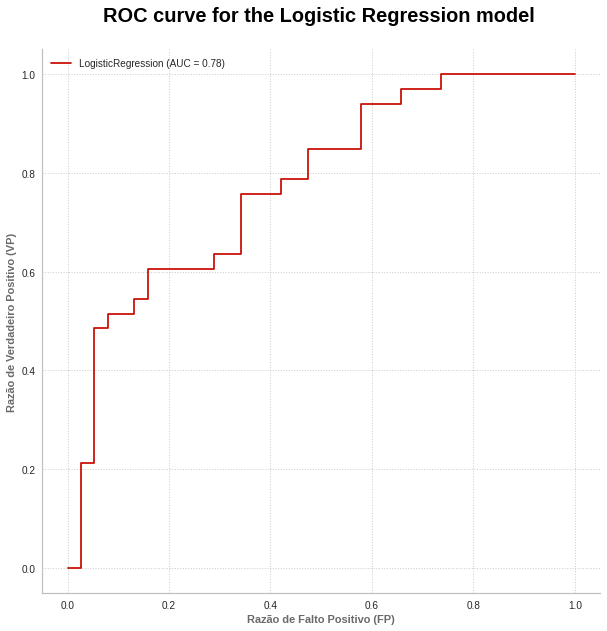

In [64]:
roc_plot(model_LR, 'Logistic Regression', data)

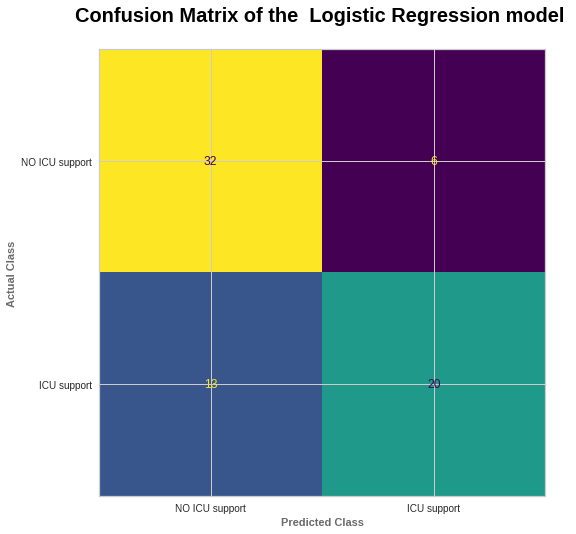

In [65]:
confusion_matrix_plot(model_LR, 'Logistic Regression', data)

In [70]:
run_model_cv(model_LR, data, n_splits=5, n_repeats=10)


AUC TEST = 0.7637317880081036 --- AUC TRAIN = 0.8327498142617122


(0.7637317880081036, 0.8327498142617122)

###Decision tree

In [ ]:
#Decision tree model
model_DT,predict_DT=decision_tree_model(data, criterion , max_depth, splitter)


#model accuracy
accuracy(data,model_LR,'Logistic Regression')

The accuracy of the Logistic Regression model is: 73.24% 


In [ ]:
run_model(data, model_LR)

AUC = 0.777511961722488

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.84      0.77        38
           1       0.77      0.61      0.68        33

    accuracy                           0.73        71
   macro avg       0.74      0.72      0.72        71
weighted avg       0.74      0.73      0.73        71



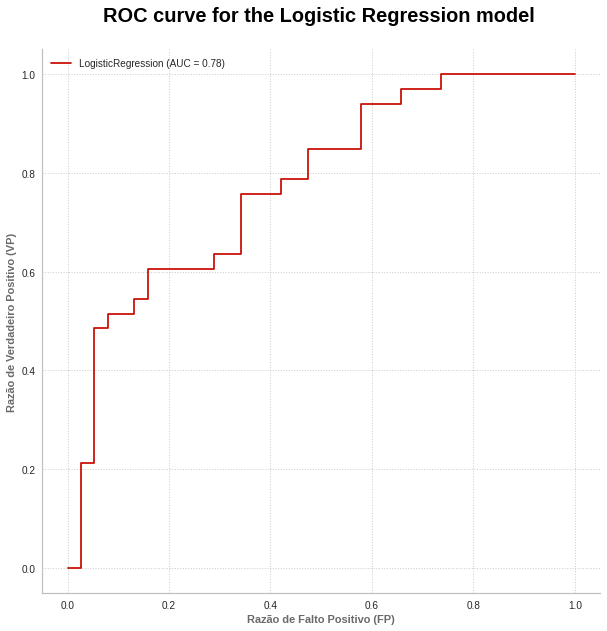

In [ ]:
roc_plot(model_LR, 'Logistic Regression', data)

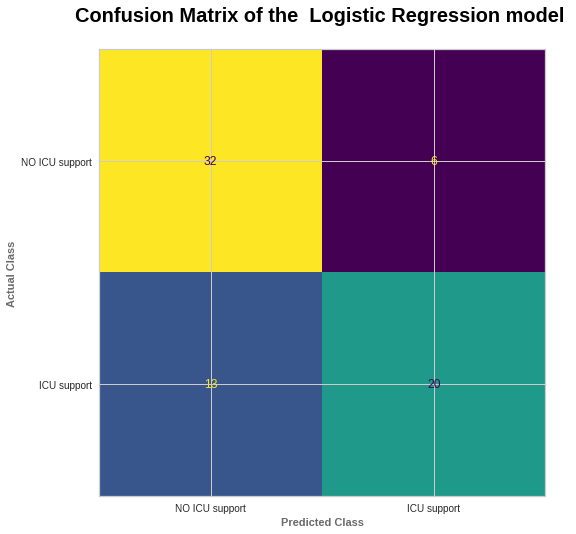

In [ ]:
confusion_matrix_plot(model_LR, 'Logistic Regression', data)